In [1]:
import numpy as np

from helperTools import *
from latticeElements.utilities import ElementTooShortError
from latticeModels import make_Ring_And_Injector, RingGeometryError, InjectorGeometryError
from latticeModels_Parameters import optimizerBounds_V1_3,injectorParamsOptimalAny
from storageRingModeler import StorageRingModel,make_Optimal_Solution_Model
from phaseSpaceAnalyzer import SwarmSnapShot
from ParticleClass import Swarm




model=make_Optimal_Solution_Model()

In [2]:
model.swarmInjectorInitial=model.generate_Swarm(1000)
h=7.5e-6
T=30.0
parallel=True
swarmInitial = model.trace_Through_Injector_And_Transform_To_Ring()
swarmTracedRing = model.swarmTracerRing.trace_Swarm_Through_Lattice(swarmInitial, h,T,
                                                               fastMode=False, accelerated=True, copySwarm=False,
                                                               parallel=parallel,stepsBetweenLogging=4)
#only particles that survived through the injector
swarmTracedRing.particles = [particle for particle in swarmTracedRing if particle.qf is not None]
print('done')

done


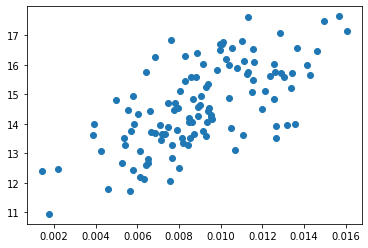

In [9]:
min_time=29.0
particles=[particle for particle in swarmTracedRing.particles if particle.T>min_time]
y= np.array([particle.qi[1] for particle in  particles])
py=np.array([particle.pi[1] for particle in particles])
plt.scatter(y,py)
plt.show()

def emmitance(qi: np.ndarray,pi: np.ndarray)-> float:
    var_qi=np.mean(qi**2)-np.mean(qi)**2
    var_pi=np.mean(pi**2)-np.mean(pi)**2
    var_qipi=np.mean(pi*qi)-np.mean(pi)*np.mean(qi)
    return np.sqrt(var_qi*var_pi - var_qipi**2)

In [10]:
xMax=max([particle.qoArr[-1,0] for particle in swarmTracedRing])
revsMax=int(xMax/model.latticeRing.totalLength)-1
min_Survival_Time=min_time
x0=1.5
epsy_list=[]
epsz_list=[]
for revs in range(0,revsMax+1,revsMax//10):
    print('------------------revs--------')
    x=x0+revs*model.latticeRing.totalLength
    t=time.time()
    snap=SwarmSnapShot(swarmTracedRing.copy(),x,min_Survival_T=min_Survival_Time)
    phaseSpace=snap.get_Surviving_Particle_PhaseSpace_Coords()
    y,py=phaseSpace[:,1],phaseSpace[:,-2]
    z,pz=phaseSpace[:,2],phaseSpace[:,-1]
    # plt.hist(pz)
    # plt.xlim([-15,15])
    # plt.show()
    # plt.hist(py)
    # plt.xlim([-15,15])
    # plt.show()
    epsy_list.append(emmitance(y,py))
    epsz_list.append(emmitance(z,pz))
    plt.scatter(y,py)
    plt.xlim([-.005,.005])
    plt.ylim([-15,15])
    plt.show()
    plt.scatter(z,pz)
    plt.xlim([-.005,.005])
    plt.ylim([-15,15])
    plt.show()

------------------revs--------



KeyboardInterrupt



In [17]:
print(swarmTracedRing.particles[0].qf)

None
